In [2]:
%matplotlib inline
%load_ext rpy2.ipython
import re
import functools
import datetime
from pbto2 import prep

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [3]:
import imp
imp.reload(prep)

<module 'pbto2.prep' from '/Users/eczech/repos/portfolio/functional/ml/python/pbto2/prep.py'>

In [106]:
d = pd.read_excel('/Users/eczech/data/ptbo2/pbto2_20151023_clean.xlsx', None)

In [107]:
is_num = lambda x: re.compile('^\d+$').match(x) is not None
d_sheet = [k for k in d.keys() if is_num(k)]
o_sheet = [k for k in d.keys() if k not in d_sheet]
len(d_sheet), o_sheet

(339, ['Outcome', 'BO2&Injy time', 'Marsh & 12mGOS', 'Demographics'])

# Measurements

## Data Exploration

In [108]:
# Find the unique set of all columns that appear in data sheets
col_lists = [[prep.normalize_col(c) for c in d[k].columns.tolist()] for k in d_sheet]
pd.Series(pd.DataFrame(col_lists).values.ravel()).order().unique()

array(['base_deficit_arterial', 'base_excess_arterial', 'blood_gases',
       'date', 'date/time', 'hco3', 'hco3a', 'icp', 'icp1', 'icp2', 'map',
       'paco2', 'pao2', 'pbto2', 'pha', 'pupil_response',
       'pupil_response_l', 'pupil_response_r', 'pupil_size',
       'pupil_size_l', 'pupil_size_r', 'sao2', 'spo2', 'uid',
       'unnamed:_14', 'unnamed:_19', 'vital_signs', None], dtype=object)

In [53]:
# Load all measurement sheets into a single data frame
dt = prep.find_sheets_by_col(d, d_sheet, None)
#dt = dt[dt['pupil_size'] != 'Neurological Assessments']
dt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24591 entries, 0 to 114
Data columns (total 28 columns):
base_deficit_arterial    4094 non-null object
base_excess_arterial     2679 non-null object
blood_gases              6754 non-null object
date                     24587 non-null datetime64[ns]
date/time                24591 non-null datetime64[ns]
hco3                     23 non-null float64
hco3a                    6702 non-null object
icp                      0 non-null float64
icp1                     16183 non-null object
icp2                     8828 non-null object
map                      15862 non-null object
paco2                    6723 non-null object
pao2                     6726 non-null object
pbto2                    24591 non-null float64
pha                      6726 non-null object
pupil_response           1664 non-null object
pupil_response_l         6675 non-null object
pupil_response_r         6643 non-null object
pupil_size               2366 non-null object


#### Account for "unnamed" Columns

In [54]:
dt[~dt['sheet_name'].isin([1051, 1055, 1046, 1052, 980])]\
    .set_index('sheet_name')[[c for c in dt if 'unnamed' in c]]\
    .dropna(how='all', axis=0).iloc[:50,:]
# This should be empty if all "Unnamed" column issues have been addressed.
# This involves at least the following updates to the input spreadsheet:
# - Add 'Vital Signs' header for patient 1046
# - Change ICP header for patient 1052 to ICP1 and ICP2

,unnamed:_14,unnamed:_19
sheet_name,,


In [55]:
dt = dt.drop([c for c in dt if 'unnamed' in c], axis=1)

#### Known Issue Adjustments

### Questions

 - Why are there ~300 patients with demographic data but no other data?
    - Number of total patient UIDs across all datasets = 622
    - Number of UIDs not in 'Marsh & 12mGOS' sheet = 307
    - Number of UIDs not in 'Outcome' sheet = 287
    - Number of UIDs not in 'BO2&Injy time' sheet = 283
    - Number of UIDs that don't have individual vitals sheets = 283
    - Number of UIDs not in 'Demographics' sheet = 0 (many of the UIDs in this sheet appear nowhere else)
 - Why do these patients have injury times in the 'Demographics' sheet that are AFTER the first recorded vital signs?
     - Bad patient UIDs: 611, 643, 659, 696, 789, 798
     - For example, patient 611 has an injury time of 4/16/2005 12:45 but first vital is at 4/16/2005 5:00
     - Are injury dates in a different TZ than datetime?
 - What does a pupil size of 'Left - 3mm, Left - 5mm, Right - 2mm, Right - 3mm' mean where there are multiple measurements for each side?
 - Same as above except for Pupil Response values like 'Left - Nonreactive, Left - Fixed, Right - Sluggish'?
 - What does it mean when PbtO2 hits 0 near end of measurements (e.g. patient 1028, 645, 1001)?
 - What's the difference between BO2 and PbtO2?  They seem to be the same, though the latter is much less sparse
 - Why are so many numeric values prefixed with 'n'?
 - More serious problems/inconsistencies:
     - _Patient/Sheet ID_ - _Cell Range_
     - Pupil size and response extend way beyond dates:
         - 953 - O98:P144
         - 952 - O110:P165
         - 949 - O94:P142
         - 947 - O101:P154
         - 938 - O106:P106
         - 933 - O99:P128
     - Huge sections of pbto2 and dates completely missing:
         - 951
         - 948
         - 945
         - 944
     - 1028 - Q78 --> Why is there an extra value when all other fields end at row 77?
     - 1058 - Q92, R92, S92 --> Same as above except there were 3 values beyond rows for other columns
     - 969 - A2 --> why is UID not equal to number of sheet?
     - 932 & 967 --> Why are pupil sizes set as dates?
     - 492 - C6 --> Why does date increase by 2 years? (Same thing happens in Demographics at cell C946)
     - 528 - C3 --> Date increases by 10 years (Same thing happens in Demographics at cell C2000)
     - 493 - C54 --> Date increases by 6 years (Same thing happens in Demographics at cell C999)
     - 'Demograhpics' sheet, patient 809 --> Date increases by 1 year at cell C13832
 - Less serious problems/inconsistencies:
     - _Patient/Sheet ID_ - _Cell Range_
     - 969 - R48 --> why is ICP '-8, 4'?
     - 760 - L5 --> What does it mean to have two values here for "Base Deficit, Arterial" (ie '16, 15')?
     - 1062 - O177 --> Where did "Neurological Assessments" come from?
     - 785 - A4 --> Why is the UID 'Br'?
     - 731 - A1 --> Why is UID column labeled UID100?
     - 542 - B1:B45 --> Why is UID column in here twice?
     - 1063, 1028, 1054 - O1:P1 --> Shouldn't these be "Pupil Size" and "Pupil Response"?
     - 1051 - T72:T73
     - 1055 - V58, V81, V87
     - 980 - T119, T121:T123
     - 812 - G108 --> How did this label get here?
     - 809 - Row 94 seems misplaced
 - Missing Headers:
     - _Patient/Sheet ID_ - _Description_
     - 1046 - 'Vital Signs' column header missing
     - 1052 - What is last column supposed to be? ICP2?

## Field Examination

### UID

In [56]:
(dt['uid'] == dt['sheet_name']).value_counts()

True    24591
dtype: int64

In [57]:
sorted(dt[dt['uid'] != dt['sheet_name']]['sheet_name'].unique())

[]

### Pupil Size

In [58]:
def type_counts(x):
    return pd.Series([v.__class__.__name__ for v in x]).value_counts()

In [59]:
dt['pupil_size'].fillna('NA').value_counts()

NA                                                                       22225
Left - 3mm, Right - 3mm                                                    820
Left - 2mm, Right - 2mm                                                    567
Left - 4mm, Right - 4mm                                                    176
Left - 2mm, Right - 4mm                                                     77
Left - 2mm, Right - 3mm                                                     73
Left - 5mm, Right - 2mm                                                     71
Left - 6mm, Right - 4mm                                                     61
Left - 8mm, Right - 6mm                                                     60
Left - 8mm, Right - 5mm                                                     47
Left - 3mm, Right - 5mm                                                     35
Left - 4mm, Right - 3mm                                                     32
Left - 3mm, Right - 2mm                             

In [60]:
dt['pupil_size_l'].fillna('NA').value_counts()

NA                  17896
3.0                  2113
2.0                  1471
3mm                   944
4.0                   568
2mm                   559
4mm                   252
5.0                   240
6.0                   113
7.0                    87
UTA                    80
6mm                    68
8.0                    60
1mm                    50
5mm                    26
9.0                    20
Unable to assess       12
1.0                    11
7mm                     8
8mm                     7
c 3mm                   1
 8mm                    1
c 5mm                   1
 1mm                    1
UTA                     1
c 2mm                   1
dtype: int64

In [61]:
dt['pupil_size_r'].fillna('NA').value_counts()

NA                  17896
3.0                  2046
2.0                  1241
3mm                   796
4.0                   532
2mm                   445
4mm                   343
5.0                   341
6.0                   201
8.0                   152
8mm                   100
9.0                    79
1mm                    74
7.0                    72
UTA                    67
Unable to assess       51
6mm                    49
5mm                    40
7mm                    23
1.0                    21
REyeSwl                 7
2.5                     5
c 3mm                   3
Swollen shut            2
 8mm                    1
c 5mm                   1
 1mm                    1
c 4mm                   1
c 2mm                   1
dtype: int64

In [62]:
type_counts(dt['pupil_size'])

float    22225
str       2366
dtype: int64

In [63]:
dprob = dt[dt['pupil_size'].apply(lambda x: not isinstance(x, str) and not pd.isnull(x))]
print('Ids with issues: ', dprob['uid'].unique())
print('Example invalid values:', dprob['pupil_size'].unique()[:3])

Ids with issues:  []
Example invalid values: []


In [64]:
x = prep.prep_pupil_size(dt.copy())
x[['pupil_size_l', 'pupil_size_r']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24591 entries, 0 to 114
Data columns (total 2 columns):
pupil_size_l    7033 non-null float64
pupil_size_r    7033 non-null float64
dtypes: float64(2)
memory usage: 576.4 KB


### Pupil Response

In [65]:
dt['pupil_response'].fillna('NA').value_counts()

NA                                                                22927
Left - Brisk, Right - Brisk                                         853
Left - Nonreactive, Right - Nonreactive                             188
Left - Sluggish, Right - Brisk                                      159
Left - Sluggish, Right - Sluggish                                   152
Left - Brisk, Right - Sluggish                                      103
Left - Fixed, Right - Sluggish                                       42
Left - Fixed, Right - Fixed                                          40
Left - Fixed, Right - Brisk                                          31
Left - Brisk, Right - Nonreactive                                    17
Left - Nonreactive, Right - Brisk                                    17
Left - Nonreactive, Left - Fixed, Right - Sluggish                   17
Left - Brisk, Right - Fixed                                          14
Left - Nonreactive, Right - Sluggish                            

In [66]:
dt['pupil_response_r'].fillna('NA').value_counts()

NA             17948
Brisk           4513
Fixed           1130
Sluggish         675
Nonreactive      232
UTA               74
Brisk             10
Birsk              3
Fixed              3
 Fixed             1
Sluggish           1
c Sluggish         1
dtype: int64

In [67]:
dt['pupil_response_l'].fillna('NA').value_counts()

NA               17916
Brisk             4972
Fixed              821
Sluggish           582
Nonreactive        154
UTA                 81
Sluggish            55
c Nonreactive        2
Birsk                1
 Fixed               1
Fixed                1
Brsik                1
Brisk                1
c Sluggish           1
 Sluggish            1
c Brisk              1
dtype: int64

In [68]:
x = prep.prep_pupil_response(dt.copy())
x[['pupil_response_l', 'pupil_response_r']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24591 entries, 0 to 114
Data columns (total 2 columns):
pupil_response_l    8258 non-null float64
pupil_response_r    8227 non-null float64
dtypes: float64(2)
memory usage: 576.4 KB


### Date Cols

In [69]:
date_cols = ['blood_gases', 'date', 'date/time', 'vital_signs']

In [70]:
x = dt.copy()
for c in date_cols:
    x[c] = x[c].apply(prep.convert_date)
x[date_cols].info()
#type_counts(dt['date/time'])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24591 entries, 0 to 114
Data columns (total 4 columns):
blood_gases    6754 non-null datetime64[ns]
date           24587 non-null datetime64[ns]
date/time      24591 non-null datetime64[ns]
vital_signs    24259 non-null datetime64[ns]
dtypes: datetime64[ns](4)
memory usage: 960.6 KB


### Floating Point Cols

In [71]:
float_cols = [
    'base_deficit_arterial', 'base_excess_arterial', 'hco3', 'hco3a', 
    'icp1', 'icp2', 'map', 'paco2', 'pao2', 'pha', 'sao2', 'spo2'
]

In [72]:
def examine(d, col):
    r = d[[col]].copy()
    r[col+'_float'] = d[col].apply(prep.extract_first_float)
    return r.drop_duplicates()
#examine(dt, 'pao2')

### Prep

In [73]:
d_meas = dt.copy()
d_meas = prep.prep_pupil_size(d_meas)
d_meas = prep.prep_pupil_response(d_meas)
for c in date_cols:
    d_meas[c] = d_meas[c].apply(prep.convert_date)
for c in float_cols:
    d_meas[c] = d_meas[c].apply(prep.extract_first_float)
d_meas = d_meas.rename(columns={'date/time': 'datetime'})

# Take only one record pertaining to each timestamp and patient, preferring those with the most data present
d_meas['num_na'] = d_meas.apply(pd.isnull).sum(axis=1)
d_meas = d_meas.groupby(['uid', 'datetime'], group_keys=False)\
    .apply(lambda x: x.sort('num_na').head(1))\
    .drop(['num_na', 'date'], axis=1)

d_meas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23671 entries, 0 to 96
Data columns (total 23 columns):
base_deficit_arterial    4083 non-null float64
base_excess_arterial     2671 non-null float64
blood_gases              6741 non-null datetime64[ns]
datetime                 23671 non-null datetime64[ns]
hco3                     23 non-null float64
hco3a                    6689 non-null float64
icp                      0 non-null float64
icp1                     15930 non-null float64
icp2                     8758 non-null float64
map                      15591 non-null float64
paco2                    6711 non-null float64
pao2                     6713 non-null float64
pbto2                    23671 non-null float64
pha                      6714 non-null float64
pupil_response_l         8176 non-null float64
pupil_response_r         8145 non-null float64
pupil_size_l             6951 non-null float64
pupil_size_r             6951 non-null float64
sao2                     4394 non-n

In [96]:
# No longer interpolating here
#d_meas = d_meas.groupby('uid', group_keys=False).apply(prep.interp_timeseries).reset_index()
#d_meas.head()

In [97]:
#d_meas.groupby('uid').size().order(ascending=False).head()

In [35]:
# def verify_timeseries(x):
#     min_date = x['datetime'].min()
#     max_date = x['datetime'].max()
#     n_hours = int((max_date - min_date).value / (1E9 * 3600.)) + 1
#     return n_hours == len(x)
# d_meas.groupby('uid').apply(verify_timeseries).value_counts()

True    339
dtype: int64

# BO2

In [109]:
d_bo2 = d['BO2&Injy time'].copy()
d_bo2.columns = [prep.normalize_col(c) for c in d_bo2]
d_bo2 = d_bo2.drop(['date'], axis=1)
d_bo2['datetime'] = d_bo2['datetime'].apply(prep.convert_date)

# Take record with max bo2 for each instance of patient and date + time
d_bo2 = d_bo2.groupby(['uid', 'datetime'], group_keys=False).apply(lambda x: x.sort('bo2').tail(1))

d_bo2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23673 entries, 0 to 24698
Data columns (total 3 columns):
uid         23673 non-null int64
bo2         23673 non-null float64
datetime    23673 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 739.8 KB


In [110]:
d_bo2.head()

,uid,bo2,datetime
0,461,21.2,2002-02-05 02:00:00
1,461,25.2,2002-02-05 05:00:00
2,461,74.5,2002-02-05 08:00:00
4,461,25.3,2002-02-05 10:00:00
5,461,40.0,2002-02-05 12:00:00


# Demographics

In [86]:
d_demo = d['Demographics'].copy()
d_demo.columns = [prep.normalize_col(c) for c in d_demo]
def prep_itime(x):
    if pd.isnull(x) or not isinstance(x, datetime.time):
        return None
    return x.hour * 3600 #+ x.minute * 60 + x.second 

d_demo['itime_sec'] = d_demo['itime'].apply(prep_itime)

def get_injury_date(x):
    v = (x['idate'].value / 1.E9)
    if not pd.isnull(x['itime_sec']):
        v += x['itime_sec']        
    return pd.to_datetime(v, unit='s')
d_demo['injury_date'] = d_demo.apply(get_injury_date, axis=1)
d_demo = d_demo.drop(['idate', 'itime', 'itime_sec'], axis=1)
d_demo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 622 entries, 0 to 621
Data columns (total 7 columns):
uid            622 non-null int64
birthdate      621 non-null datetime64[ns]
age            622 non-null int64
sex            621 non-null float64
gcs            620 non-null float64
death_date     254 non-null datetime64[ns]
injury_date    622 non-null datetime64[ns]
dtypes: datetime64[ns](3), float64(2), int64(2)
memory usage: 38.9 KB


In [89]:
# Make sure there is only one outcome record per patient
assert d_demo.groupby('uid').size().max() == 1, 'Found multiple outcomes for same uid'

# Marshall Scores

In [90]:
d_marsh = d['Marsh & 12mGOS'].copy()
d_marsh = d_marsh.drop('gos12', axis=1)
d_marsh.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 415 entries, 0 to 414
Data columns (total 2 columns):
uid         415 non-null int64
marshall    413 non-null float64
dtypes: float64(1), int64(1)
memory usage: 9.7 KB


In [91]:
def resolve_duplicates(x):
    if len(x) == 1:
        return x
    if len(x['marshall'].unique()) != 1:
        raise ValueError('UID {} has multiple marshall scores that are not the same: {}'
                         .format(x['uid'].iloc[0], x['marshall'].unique()))
    return x.head(1)
d_marsh = d_marsh.groupby('uid', group_keys=False).apply(resolve_duplicates).dropna()

In [92]:
# Make sure there is only one outcome record per patient
assert d_marsh.groupby('uid').size().max() == 1, 'Found multiple outcomes for same uid'

# Outcomes

In [93]:
d_outcome = d['Outcome'].copy()
d_outcome.columns = [prep.normalize_col(c) for c in d_outcome]
d_outcome.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1230 entries, 0 to 1229
Data columns (total 3 columns):
uid                        1230 non-null int64
post_injury_test_period    1230 non-null object
gos                        1090 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 38.4+ KB


In [94]:
d_outcome['post_injury_test_period'].value_counts()

6 month     321
3 month     321
12 month    317
24 month    271
dtype: int64

In [95]:
d_outcome = d_outcome.set_index(['uid', 'post_injury_test_period']).unstack()
d_outcome.columns = ['{}-{}'.format(c[0], c[1].lower().replace('month', '').strip()) for c in d_outcome]
d_outcome = d_outcome.reset_index()
d_outcome.head()

,uid,gos-12,gos-24,gos-3,gos-6
0,461,1,1,1,1
1,462,5,5,3,4
2,463,3,3,2,2
3,464,2,2,2,2
4,466,2,2,2,2


In [96]:
# Make sure there is only one outcome record per patient
assert d_outcome.groupby('uid').size().max() == 1, 'Found multiple outcomes for same uid'

# Merge Pre-Checks

In [97]:
# Determine the unique set of patient ids present across all datasets
d_all = {'d_meas': d_meas, 'd_bo2': d_bo2, 'd_demo': d_demo, 'd_marsh': d_marsh, 'd_outcome': d_outcome}
uid = []
for d in d_all.values():
    uid.extend(d['uid'].unique())
uid = np.unique(uid)
print('Number of patients total = {}'.format(len(uid)))

# Determine the number of uids NOT present in the overall set for each dataset
for d in d_all:
    print('Number of UIDs missing in dataset {} = {}'.format(d, len(np.setdiff1d(uid, d_all[d]['uid'].unique()))))
    

Number of patients total = 622
Number of UIDs missing in dataset d_meas = 283
Number of UIDs missing in dataset d_outcome = 287
Number of UIDs missing in dataset d_bo2 = 283
Number of UIDs missing in dataset d_demo = 0
Number of UIDs missing in dataset d_marsh = 309


From this, it seems safe to conclude that many of the "Demographic" patient records don't necessarily have other records so they'll be ignored for now.

# Feature Generation

In [98]:
d_meas['uid'].dtype, d_demo['uid'].dtype, d_bo2['uid'].dtype, d_outcome['uid'].dtype

(dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'))

In [99]:
# Join the only two datasets that have records over time 
# (all others are specific to a patient but do not vary in time)
d_exp = pd.merge(d_meas, d_bo2, how='outer', on=['uid', 'datetime'])

# Join the above to demographic data, ignoring demographic records that do not match
d_exp = pd.merge(d_exp, d_demo, how='left', on=['uid'])

# Make sure there were no records in 'd_exp' without a record in 'd_demo'
assert d_exp['injury_date'].isnull().sum() == 0, 'Found vital signs data with no corresponding demographic record'
# Make sure non of the vital signs records have a null date
assert d_exp['datetime'].isnull().sum() == 0, 'Found vital signs record with null date'

d_exp['uid'] = d_exp['uid'].astype(np.int64)
d_exp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23673 entries, 0 to 23672
Data columns (total 30 columns):
base_deficit_arterial    4083 non-null float64
base_excess_arterial     2671 non-null float64
blood_gases              6741 non-null datetime64[ns]
datetime                 23673 non-null datetime64[ns]
hco3                     23 non-null float64
hco3a                    6689 non-null float64
icp                      0 non-null float64
icp1                     15930 non-null float64
icp2                     8758 non-null float64
map                      15591 non-null float64
paco2                    6711 non-null float64
pao2                     6713 non-null float64
pbto2                    23671 non-null float64
pha                      6714 non-null float64
pupil_response_l         8176 non-null float64
pupil_response_r         8145 non-null float64
pupil_size_l             6951 non-null float64
pupil_size_r             6951 non-null float64
sao2                     4394 no

In [100]:
def get_times(x):
    # Add time since injury value to data frame for patient
    x['tsi'] = x['datetime'] - x['injury_date']
    x['tsa'] = x['datetime'] - x['datetime'].min()
    return x
d_exp = d_exp.groupby('uid', group_keys=False).apply(get_times)
d_exp['tsi_min'] = [int(x.value / (1E9 * 60)) for x in d_exp['tsi']]
d_exp['tsa_min'] = [int(x.value / (1E9 * 60)) for x in d_exp['tsa']]

d_exp[['tsi', 'tsi_min', 'tsa', 'tsa_min']].head()

,tsi,tsi_min,tsa,tsa_min
0,1 days 05:00:00,1740,00:00:00,0
1,1 days 08:00:00,1920,03:00:00,180
2,1 days 11:00:00,2100,06:00:00,360
3,1 days 13:00:00,2220,08:00:00,480
4,1 days 15:00:00,2340,10:00:00,600


In [101]:
# Find patients with injury dates recorded as after first vital signs (shouldn't be possible)
bad_uids = [int(v) for v in d_exp[d_exp['tsi_min'] <= 0]['uid'].unique()]

# Set all tsi_min values to NA for these patients
d_exp['tsi_min'] = d_exp['tsi_min'].where(~d_exp['uid'].isin(bad_uids), np.nan)

bad_uids

[611, 643, 659, 696, 789, 798]

count    23673.000000
mean      3105.563300
std       2143.671294
min          0.000000
25%       1320.000000
50%       2820.000000
75%       4620.000000
max      15600.000000
Name: tsa_min, dtype: float64


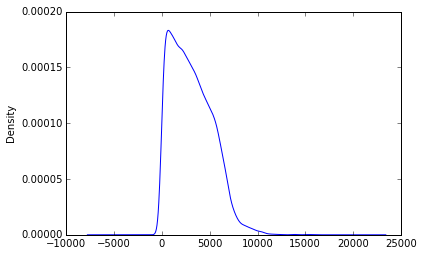

In [102]:
print(d_exp['tsa_min'].describe())
d_exp['tsa_min'].plot(kind='kde')

### Merge Other Datasets

In [103]:
d_exp = pd.merge(d_exp, d_marsh, how='left', on=['uid'])
d_exp = pd.merge(d_exp, d_outcome, how='left', on=['uid'])
d_exp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23673 entries, 0 to 23672
Data columns (total 39 columns):
base_deficit_arterial    4083 non-null float64
base_excess_arterial     2671 non-null float64
blood_gases              6741 non-null datetime64[ns]
datetime                 23673 non-null datetime64[ns]
hco3                     23 non-null float64
hco3a                    6689 non-null float64
icp                      0 non-null float64
icp1                     15930 non-null float64
icp2                     8758 non-null float64
map                      15591 non-null float64
paco2                    6711 non-null float64
pao2                     6713 non-null float64
pbto2                    23671 non-null float64
pha                      6714 non-null float64
pupil_response_l         8176 non-null float64
pupil_response_r         8145 non-null float64
pupil_size_l             6951 non-null float64
pupil_size_r             6951 non-null float64
sao2                     4394 no

# Export

In [104]:
d_exp.to_pickle('/Users/eczech/data/ptbo2/export/data_clean.pkl')